In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from BIpy.data_processing import get_sliding_window_partition, LowpassWrapper



class DummyClassifier():
    """Dummy classifier for testing purpose"""
    def __init__(self):
        self.window_size = 1

    def predict_proba(self, data):
        """returns input[0]"""
        # print('predict_proba:', data)
        return data[0]


# window size in samples, not seconds
def get_trained_CSP_LDA(data, labels, window_size=None, preprocessing=LowpassWrapper()):
    """Returns a trained sklearn pipeline of [csp, lda]

    Parameters
    ----------
    data : np.array
        Data to train the classifier on
        Shape (trials, channels, time)
    labels : np.array
        1d array of labels to the training data
    window_size : int
        Size in samples (not seconds) the classifier should be trained on
        If None, the function will trian with each entire trial as input
        Default None
    preprocessing : object implementing fit_transform and transform
        Preprocessing step to add at the beggining of the sklearn pipeline
        Default BIpy.preprocessing.LowpassWraspper()

    Returns
    -------
    clf
        A trained csp + lda Pipeline
    """

    if not (window_size == None or window_size == data.shape[-1]):
        # slide window over trial data to generate many more data points
        data, labels = get_sliding_window_partition(data, labels, window_size)



    # make pipeline
    preproc = preprocessing
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=10, reg=None, log=None, norm_trace=False, component_order='alternate')
    clf = Pipeline([(str(preproc), preproc), ('CSP', csp), ('LDA', lda)])

    # train model
    clf.fit(data, labels)

    # return trained model
    return clf


# [NOTE]: extend this so it generalizes to gell eeg
class WrappedCSPLDAClassifier():
    """Wrapper class for using an sklearn csp+lda pipeline in a BIpy.bci.ClassifierProcess

    Methods
    -------
    predict_proba(self, window: np.array)
        takes the output form a WindowInlet and returns the probability (according to the csp+lda classifier) that the right hand was imagined
    def fit(self, data, labels):
        calls fit(data, labels) on the csp+lda classifier
    
    """    

    def __init__(self, data_channels=list(range(20)), window_size=1000, preprocessing=LowpassWrapper()):
        """
            Parameters
            ----------
            data_channels : int, default list(range(20))
                Channels that the classifier should use as input
            window_size : int, default 1000
                number of samples of eeg data the classifier should use as input
            preprocessing : default LowpassWrapper()
                Step added to the start of the csp+lda sklearn pipeline
        """
        
        self.window_size=window_size
        self.data_channels = data_channels

        # make pipeline
        preproc = preprocessing
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=10, reg=None, log=None, norm_trace=False, component_order='alternate')
        self.clf = Pipeline([(str(preproc), preproc), ('CSP', csp), ('LDA', lda)])

    def predict_proba(self, window: np.array):
        """takes the output form a WindowInlet and returns the probability (according to the csp+lda classifier) that the right hand was imagined"""
        
        data = np.transpose(np.array(window))[self.data_channels]
        # print('data shape in wrapped:', data.shape)
        proba = self.clf.predict_proba([data])
        return proba[0][1] # proba = [[prob_left, prob_right]]


    def fit(self, data, labels):
        """calls fit(data, labels) on the csp+lda classifier"""
        self.clf.fit(data, labels)
        

In [27]:
data = np.load('actually_good_data.npy')
labels = np.load('actually_good_labels.npy')

In [28]:
labels.shape
data.shape

(60, 20, 2000)

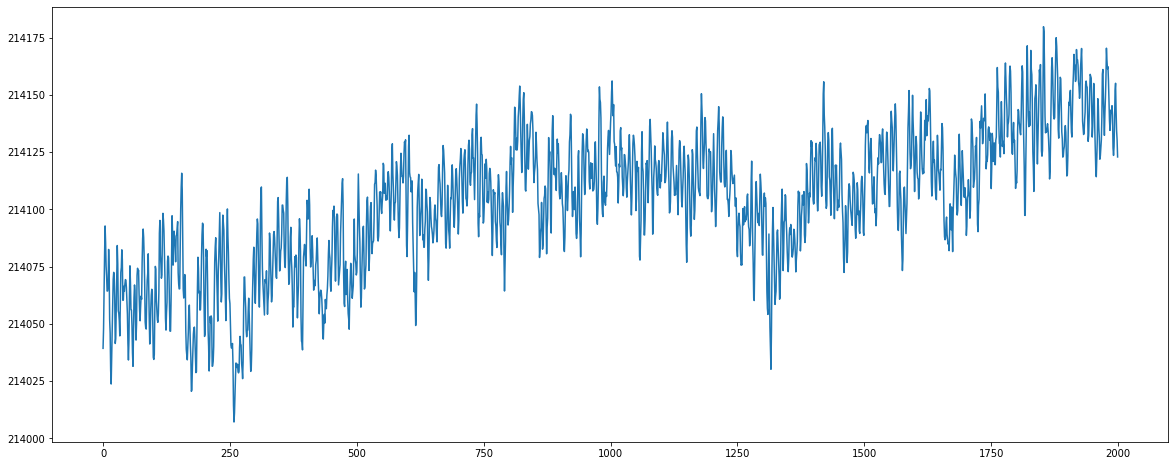

In [40]:
plt.figure(figsize=(20,8))
plt.plot(data[24,17,:])

(5.0, 50.0)

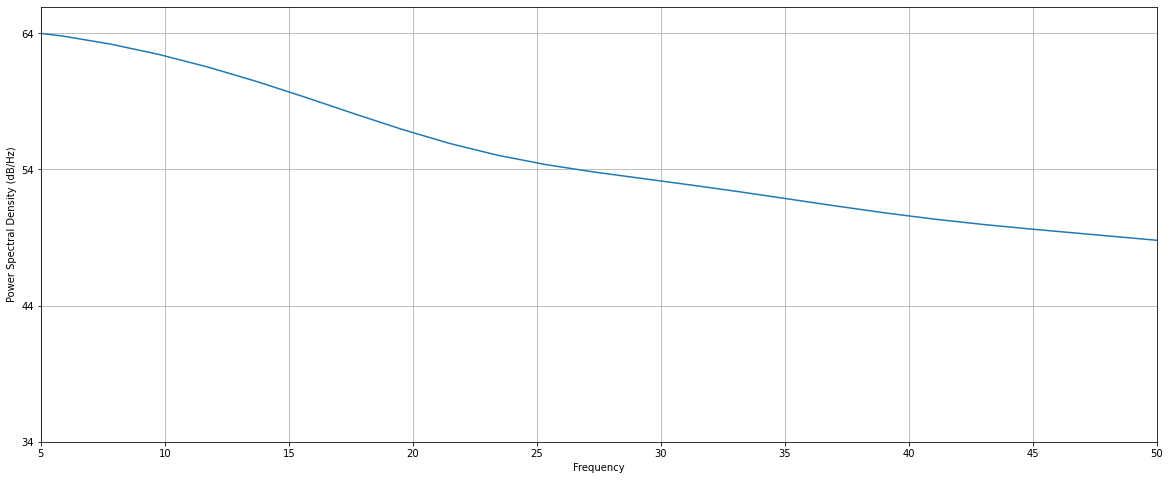

In [68]:
# check fft
# plt.psd(np.mean(data[13], axis=0), Fs=500)
plt.figure(figsize=(20,8))
plt.psd(data[[not l for l in labels],17], Fs=500)
plt.xlim(left=5,right=50)

In [ ]:
clf = get_trained_CSP_LDA(data[:30], labels[:30], window_size=None)

In [ ]:
clf.score(data[30:], labels[30:])

In [ ]:
labels

In [ ]:
cross_val_score(clf, data, labels, cv=3)

In [ ]:
def get_shuffi():
    shufi = list(range(30))
    random.shuffle(shufi)
    return shufi

acc = np.mean(np.array([cross_val_score(clf, data[shufi], labels[shufi], cv=5) for shufi in [get_shuffi() for i in range(10)]]))
acc

In [2]:
from pylsl import resolve_stream, StreamInlet

In [3]:
streams = resolve_stream('source_id', 'myuid323457')

In [4]:
inlet = StreamInlet(streams[0])

(1024, 25)

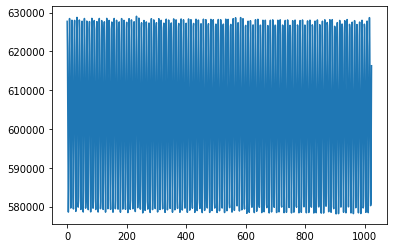

In [23]:
# inlet.pull_chunk(max_samples=100000)
chunk, t = inlet.pull_chunk()#, max_samples=50)
chunk = np.array(chunk)
plt.plot(chunk[:,15])
chunk.shape

In [26]:
np.array(inlet.pull_chunk()[0]).shape

(1024, 25)

Stream transmission broke off (Input stream error.); re-connecting...
